In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyoso import Client
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

stringify = lambda arr: "'" + "','".join(arr) + "'"

In [3]:
# Analysis parameters
MOST_RECENT_MEASUREMENT_PERIOD = 6

HISTORIC_START_DATE = "2023-01-01"
HISTORIC_END_DATE   = "2025-07-31"

DAILY_START_DATE = "2025-01-01"
DAILY_END_DATE   = "2025-07-31"

MONTHLY_START_DATE = "2025-01-01"
MONTHLY_END_DATE   = "2025-07-01"

RETROFUNDING_REPO_URL = "https://raw.githubusercontent.com/ethereum-optimism/Retro-Funding/refs/heads/main/results/S7"
OP_RED = "#FF0420"

In [23]:
def get_round_results(m_id, category):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/outputs/{category}__results.json"
    result = pd.read_json(url)
    result = result[['op_atlas_id', 'op_reward']]
    result.columns = ['atlas_id', 'op_reward']
    result['category'] = category
    result['measurement_period'] = m_id
    return result

def get_all_round_results(category):
    dfs = []
    for m_id in range(1, MOST_RECENT_MEASUREMENT_PERIOD + 1):
        dfs.append(get_round_results(m_id, category))
    return pd.concat(dfs, axis=0, ignore_index=True)

dates = {
    1: '2025-04-05',
    2: '2025-05-02',
    3: '2025-05-21',
    4: '2025-06-09',
    5: '2025-07-07',
    6: '2025-08-06'
}
dates = {x: pd.to_datetime(y) for x,y in dates.items()}

df_funding = get_all_round_results("onchain")
df_funding = df_funding[df_funding['op_reward'] > 0]
df_funding['funding_date'] = df_funding['measurement_period'].map(dates)
df_funding

,atlas_id,op_reward,category,measurement_period,funding_date
0,0x0008577196fa6ec286440b418e2f6305fc10e62ce759...,1367.00,onchain,1,2025-04-05
1,0x000c2ce4773defb3010a58d3800d0ec9d432189c574b...,7718.74,onchain,1,2025-04-05
2,0x02065e72fe4eebfa1ebca19238e6147c8571c2b7fefa...,576.41,onchain,1,2025-04-05
5,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,66666.67,onchain,1,2025-04-05
6,0x098fca4a62159ddfc2c45dc2931a727d56f039b8f68e...,5757.66,onchain,1,2025-04-05
...,...,...,...,...,...
1568,0xfc54b4a9c537be25238cba3f05100b733aeee83a3eb3...,2937.73,onchain,6,2025-08-06
1570,0xfd9f98de666c5b0a5ce96d4a4b8d4ceee9f8c2156734...,827.65,onchain,6,2025-08-06
1571,0xfe8e35b3487bd0e0457b9431b12b73403ca1f5c9c19d...,219.56,onchain,6,2025-08-06
1572,0xff1edf67227651293a9cff4dce3577c6ca52bf8c7c6f...,1496.36,onchain,6,2025-08-06


In [15]:
df_metrics = client.to_pandas(f"""
SELECT
  sample_date,
  project_name AS atlas_id,
  projects_v1.display_name AS application_name,
  amount
FROM timeseries_metrics_by_project_v0
JOIN metrics_v0 using (metric_id)
JOIN projects_v1 using (project_id)
WHERE
  project_name IN ({stringify(df_onchain_rewards['atlas_id'].unique())})
  AND metric_name = 'WORLDCHAIN_worldchain_users_aggregation_daily'
  AND sample_date < DATE('{DAILY_END_DATE}')
ORDER BY sample_date  
""")

df_metrics['sample_date'] = pd.to_datetime(df_metrics['sample_date'])
df_metrics.tail()

,sample_date,atlas_id,application_name,amount
6215,2025-07-30,0x42bdd05fa3beb0b21780bbd35b34eefc3e69e45bc4f1...,Superhero,3157
6216,2025-07-30,0x2bdfa034cf1e853db8ed4b30531270c7a62d66550cd2...,Cash Convert,33173
6217,2025-07-30,0x12721a0927c5d0598380e718e69c7f3395cc7b8847da...,AION,9962
6218,2025-07-30,0x2c41bf7b4d36a344881581e20ecb2929d38c3415fffa...,PUF,14644
6219,2025-07-30,0x8fbddc02ddbc9c9b303b7bbb645aa933541876a31a93...,Holdstation Wallet,10392


In [29]:
mini_apps = list(df_metrics['atlas_id'].unique())
df_funding[df_funding['atlas_id'].isin(mini_apps)].groupby('funding_date')['op_reward'].sum().cumsum()

funding_date
2025-04-05     197860.73
2025-05-02     382919.50
2025-05-21     709184.11
2025-06-09    1058712.08
2025-07-07    1400819.55
2025-08-06    1763943.33
Name: op_reward, dtype: float64

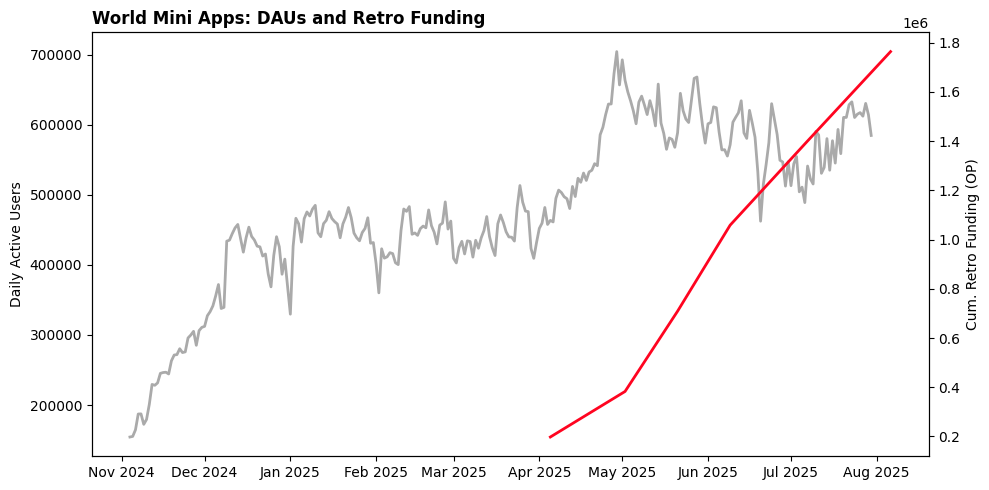

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

sns.lineplot(
    data=df_metrics
        .groupby('sample_date', as_index=False)['amount']
        .sum(),
    x='sample_date',
    y='amount',
    color='#aaa',
    linewidth=2,
    ax=ax
)

funding = (
    df_funding[df_funding['atlas_id'].isin(mini_apps)]
      .groupby('funding_date', as_index=False)['op_reward']
      .sum()
)
funding['cum_op_reward'] = funding['op_reward'].cumsum()

sns.lineplot(
    data=funding,
    x='funding_date',
    y='cum_op_reward',
    color='#ff0420',
    linewidth=2,
    ax=ax2
)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_ylabel('Daily Active Users')
ax2.set_ylabel('Cum. Retro Funding (OP)')
ax.set_xlabel('')
ax.set_title('World Mini Apps: DAUs and Retro Funding', loc='left', weight='bold')
fig.tight_layout()
plt.show()

Pearson corr = 0.04


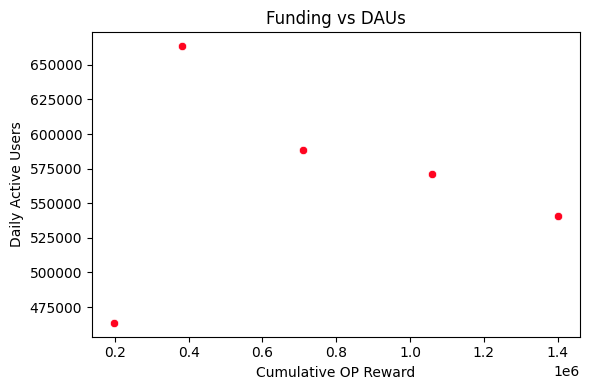

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

ts_activity = (
    df_metrics
      .groupby('sample_date', as_index=False)['amount']
      .sum()
      .rename(columns={'sample_date': 'date', 'amount': 'activity'})
)
ts_funding = (
    df_funding[df_funding['atlas_id'].isin(mini_apps)]
      .groupby('funding_date', as_index=False)['op_reward']
      .sum()
      .assign(cum_op_reward=lambda d: d['op_reward'].cumsum())
      .rename(columns={'funding_date': 'date'})
)

df = pd.merge(ts_activity, ts_funding[['date','cum_op_reward']], on='date', how='inner')
pearson_corr = df['activity'].corr(df['cum_op_reward'])
print(f'Pearson corr = {pearson_corr:.2f}')
plt.figure(figsize=(6,4))
sns.scatterplot(x='cum_op_reward', y='activity', data=df, color='#ff0420')
plt.xlabel('Cumulative OP Reward')
plt.ylabel('Daily Active Users')
plt.title('Funding vs DAUs')
plt.tight_layout()
plt.show()